# ripe or rotten mango?

### imports

En esta sección se instalan las dependencias e importan las librerías necesarias para manipulación de datos, preprocesamiento, visualización y modelos de machine learning.

In [1]:
%reload_ext autoreload
%autoreload 2
%pip install -q -r ../requirements.txt

import sys
sys.path.append('../')  

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import pandas as pd 
from src import get_dataset, preprocess, graphic, mv_regression, decision_tree, random_forest, neural_network, deep_neural_network

Note: you may need to restart the kernel to use updated packages.


### manejo de datos

Se descarga el conjunto de datos o en su defecto se carga de un archivo `train.csv` y creamos un DataFrame con los datos de entrenamiento para una inspección y análisis inicial.

In [2]:
dataset = get_dataset()
train_data = pd.DataFrame(dataset.train_data)
print(f"Train dataset shape: {train_data.shape}")

Loaded dataset ../data/raw\train.csv in 0.01 seconds.
Loaded dataset ../data/raw\validation.csv in 0.01 seconds.
Train dataset shape: (1989, 2)


### feature engineering

Inicializamos el preprocesamiento a partir del conjunto de datos de entrenamiento para extraer características y aplicar PCA, organizando los resultados en los DataFrames `features_data` y `pca_data` para su análisis y modelado posterior.

In [3]:
processor = preprocess(dataset.train_data)

features_data = pd.DataFrame(processor.features_data)
print(f"Features shape: {features_data.shape}")
features_data.describe()

Loaded dataset ../data/processed\features.csv in 0.85 seconds.
Loaded dataset ../data/processed\pca.csv in 0.05 seconds.
Features shape: (1989, 776)


,area,label,mean_r,mean_g,mean_b,std_dev_r,std_dev_g,std_dev_b,hist_0,hist_1,...,hist_758,hist_759,hist_760,hist_761,hist_762,hist_763,hist_764,hist_765,hist_766,hist_767
count,1.989000e+03,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,...,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000
mean,6.685059e+04,0.249874,181.854046,155.196007,126.786020,26.639887,27.660354,36.437425,0.295123,0.091503,...,25.862242,34.162896,25.896430,33.275013,39.687783,50.937657,53.144796,66.493213,218.011564,874.575163
std,8.864969e+04,0.433049,34.294345,38.557030,45.728988,10.555681,10.600771,17.150335,2.651806,1.208485,...,155.273770,251.887797,101.293353,146.106492,123.184643,469.349899,336.739000,451.837125,1231.088768,4440.192961
min,1.083000e+03,0.000000,76.756836,67.474856,14.339593,3.827603,5.637942,7.884951,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.530400e+04,0.000000,153.235232,130.185822,92.556163,18.003269,20.049799,22.960395,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.800500e+04,0.000000,177.447050,150.294597,128.293459,26.102443,25.818547,34.824957,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.991000e+04,0.000000,205.149231,177.272506,150.121064,32.858022,32.503474,45.783679,0.000000,0.000000,...,7.000000,5.000000,7.000000,7.000000,7.000000,6.000000,5.000000,6.000000,3.000000,13.000000
max,1.272680e+06,1.000000,254.209087,253.923098,252.875468,76.380757,104.556292,116.152947,53.000000,45.000000,...,4188.000000,6895.000000,2542.000000,2699.000000,1415.000000,16237.000000,13600.000000,14016.000000,36807.000000,40262.000000


In [4]:
pca_data = pd.DataFrame(processor.pca_data)
print(f"PCA features shape: {pca_data.shape}")
pca_data.describe()

PCA features shape: (1989, 19)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,1989.000000,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03
mean,0.000000,5.715779e-17,-7.144723e-18,1.143156e-16,-2.857889e-17,-3.429467e-16,3.715256e-16,4.001045e-16,-8.002090e-16,2.586390e-15,6.430251e-17,-2.314890e-15,4.001045e-16,2.857889e-16,3.143678e-16,-1.643286e-15,8.859457e-16,6.287357e-16,1.271761e-15
std,1.000251,1.624472e+00,1.382951e+00,1.100234e+01,1.022334e+01,7.996838e+00,6.566725e+00,6.121897e+00,5.698542e+00,5.421977e+00,4.841078e+00,4.401756e+00,4.320416e+00,4.214642e+00,3.826726e+00,3.771763e+00,3.473469e+00,3.198674e+00,3.119633e+00
min,-0.742068,-3.344345e+00,-5.378656e+00,-2.707418e+01,-1.615096e+01,-1.421712e+01,-2.815532e+01,-9.306891e+01,-4.364579e+01,-4.613374e+01,-3.060395e+01,-3.251611e+01,-5.926320e+01,-3.642001e+01,-2.048225e+01,-1.906665e+01,-2.449946e+01,-2.836049e+01,-1.588062e+01
25%,-0.468778,-1.089600e+00,-5.905019e-01,-7.940474e+00,-4.326469e+00,-4.335032e+00,-4.549375e+00,-3.362698e+00,-2.384659e+00,-3.437807e+00,-1.180831e+00,-1.599074e+00,-1.523205e+00,-1.553434e+00,-1.232057e+00,-1.578625e+00,-1.185060e+00,-1.093121e+00,-1.407513e+00
50%,-0.212638,-1.001513e-01,7.398179e-02,-3.461190e+00,-3.044794e+00,-2.038845e+00,-7.364211e-01,-6.080568e-01,-7.631851e-01,4.096209e-01,3.112862e-01,2.792869e-01,7.531586e-02,-3.359760e-01,-4.253414e-01,-1.095953e-01,-8.898114e-02,1.422287e-01,6.228931e-02
75%,0.034520,8.436559e-01,7.942833e-01,5.704508e+00,5.761104e-02,2.664355e+00,3.360559e+00,2.843593e+00,2.409743e+00,2.419245e+00,1.777450e+00,1.929384e+00,1.599034e+00,1.392389e+00,9.553843e-01,1.477512e+00,1.287232e+00,1.143089e+00,1.217613e+00
max,13.605605,6.840655e+00,7.599727e+00,4.191608e+01,6.954312e+01,7.790614e+01,2.684670e+01,2.389603e+01,6.501570e+01,2.815332e+01,1.156463e+02,4.090934e+01,2.547260e+01,7.574239e+01,3.789811e+01,2.798539e+01,3.401324e+01,1.873105e+01,2.898870e+01


### exploración

La clase `graphic` proporciona métodos para visualizar los datos extraídos, generar histogramas, analizar estadísticas de los canales de color RGB, explorar correlaciones y visualizar el análisis de componentes principales (PCA) aplicado a las características de las imágenes de mangos en el conjunto de datos.

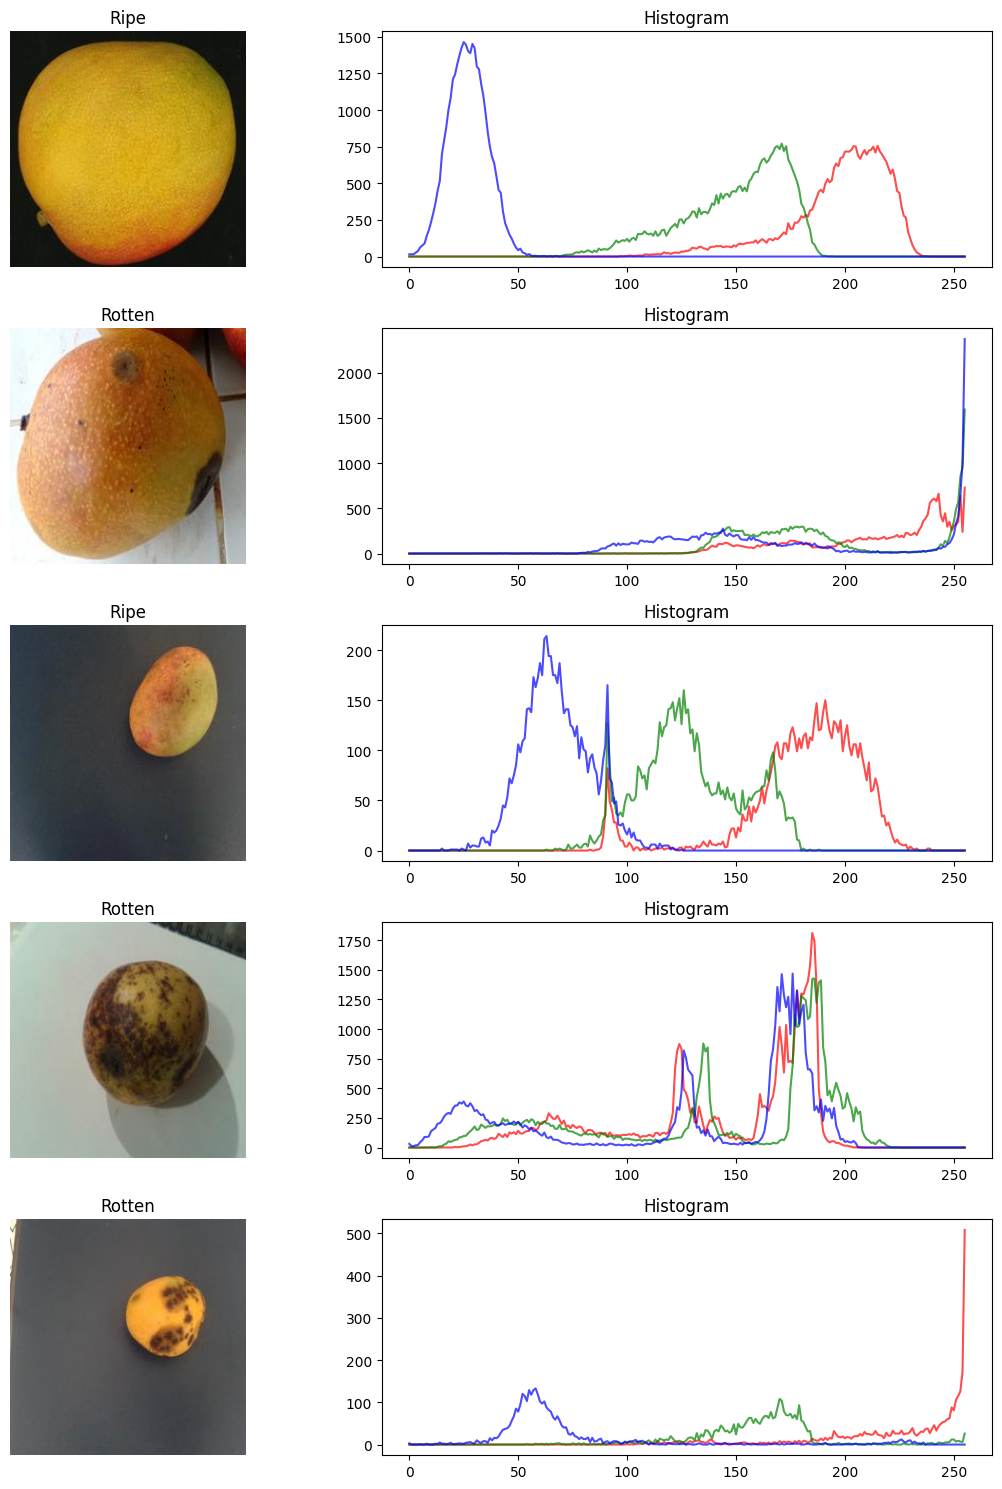

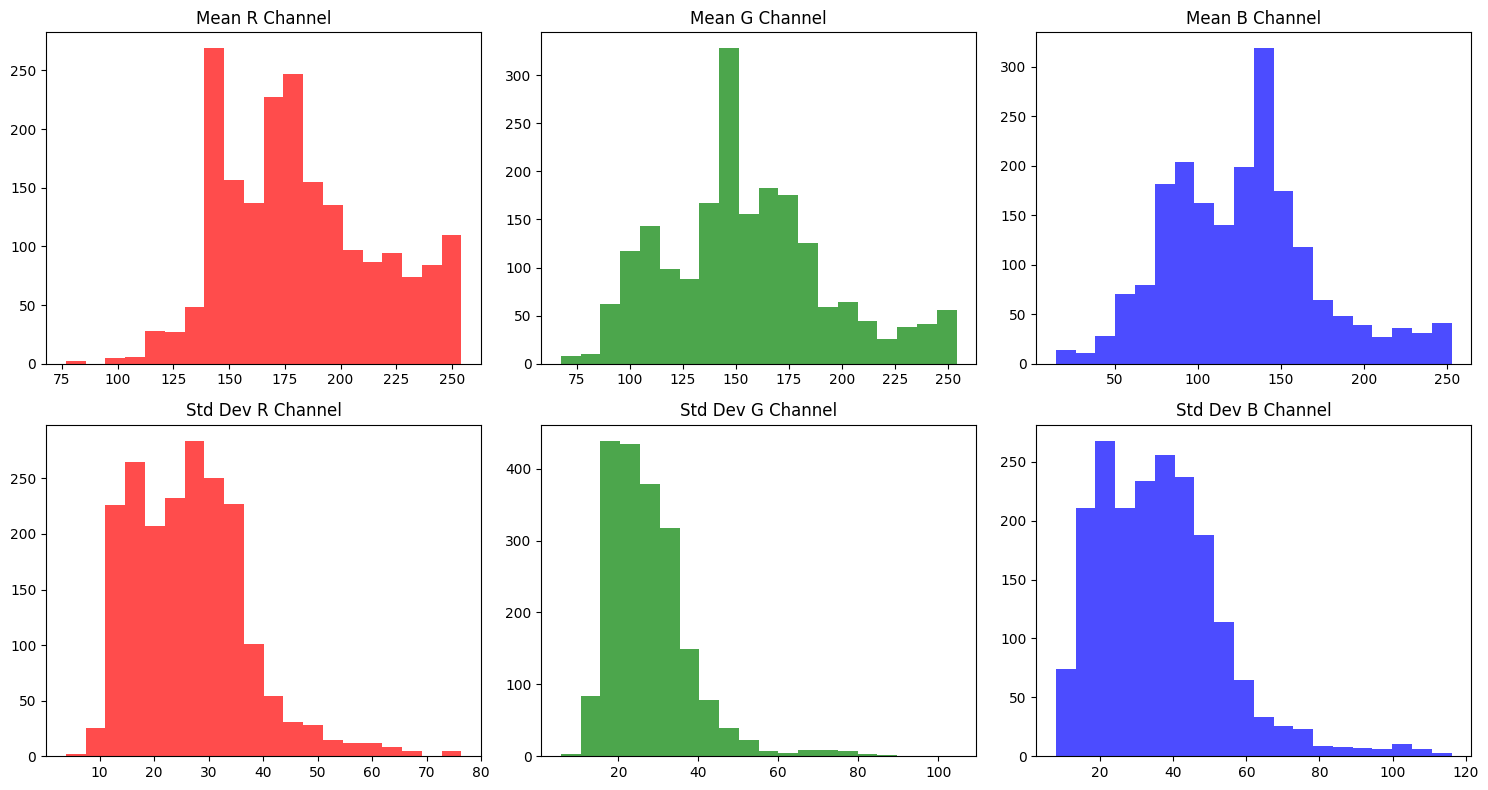

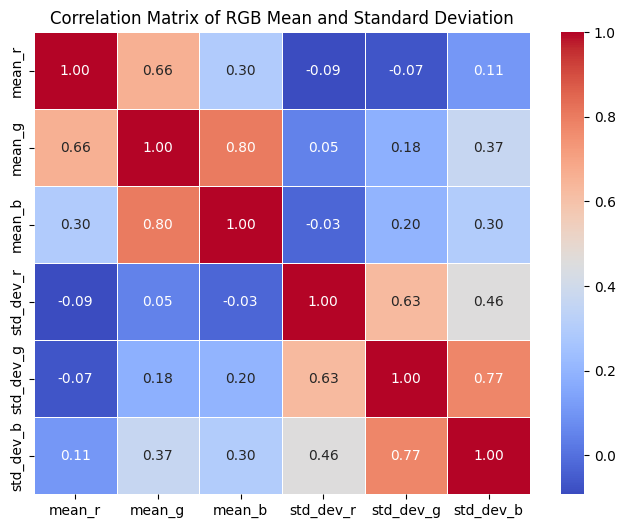

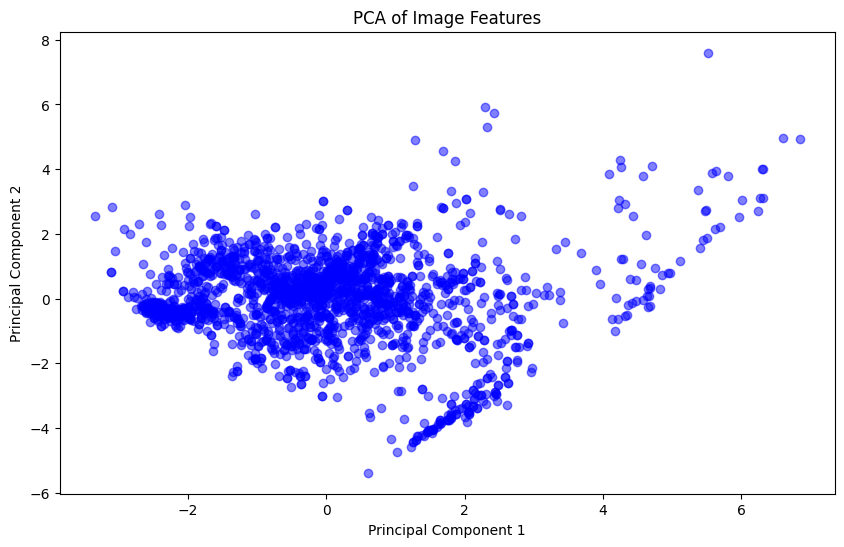

In [5]:
stats = features_data[['mean_r', 'mean_g', 'mean_b', 'std_dev_r', 'std_dev_g', 'std_dev_b']]
pca_x, pca_y = pca_data['1'], pca_data['2']

graphic.show_samples(train_data, features_data)
graphic.show_channels(stats)
graphic.show_correlation(stats)
graphic.show_pca(pca_x, pca_y)

In [6]:
rnd = random_forest(features_data, train_data['label'])

Model trained successfully.
Accuracy: 0.9874

Classification Report:
              precision    recall  f1-score   support

        Ripe       1.00      0.95      0.98       104
      Rotten       0.98      1.00      0.99       294

    accuracy                           0.99       398
   macro avg       0.99      0.98      0.98       398
weighted avg       0.99      0.99      0.99       398

Confusion Matrix:
[[ 99   5]
 [  0 294]]
